## Importer les libraries

In [21]:
import pandas as pd
import numpy  as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ...Prediction.utilities.Path_Join import p_join

from ...Prediction.Traitement_image.Preprocessing_functions.ApplyMask import ApplyMask
from ...Prediction.Traitement_image.Preprocessing_functions.CLAHE import clahe
from ...Prediction.Traitement_image.Preprocessing_functions.Crop_Borders import CropBorders
from ...Prediction.Traitement_image.Preprocessing_functions.Flipping import flip
from ...Prediction.Traitement_image.Preprocessing_functions.Global_Binarize import GlobalBinarise
from ...Prediction.Traitement_image.Preprocessing_functions.Largest_Blob import XLargestBlobs
from ...Prediction.Traitement_image.Preprocessing_functions.Normalise import minmaxnormalise
from ...Prediction.Traitement_image.Preprocessing_functions.Open_Mask import openmask
from ...Prediction.Traitement_image.Preprocessing_functions.Padding import pad

## Lire Les images

In [3]:
parent_dir =r"C:\Users\Asus\PycharmProjects\pythonProject\Dataset\Patients"
df = pd.read_excel (r'C:\Users\Asus\Desktop\PCD\Organized dataset\metadata\metadata_good.xlsx')
ROI_mask_paths=df['ROI mask file path']
im_paths = df['image full mammo path']

In [4]:
sample = (list(im_paths)[:5])
ROI_mask_paths_sample = (list(ROI_mask_paths)[:5])

In [5]:
sample_im = [p_join(parent_dir,path) for path in sample]
sample_ROI_mask = [p_join(parent_dir,path) for path in ROI_mask_paths_sample]

## Affichage des clichées mammaires (échantillon)

In [6]:
read_im = [mpimg.imread(path) for path in sample_im]
sample_ROI_im = [mpimg.imread(path) for path in sample_ROI_mask]

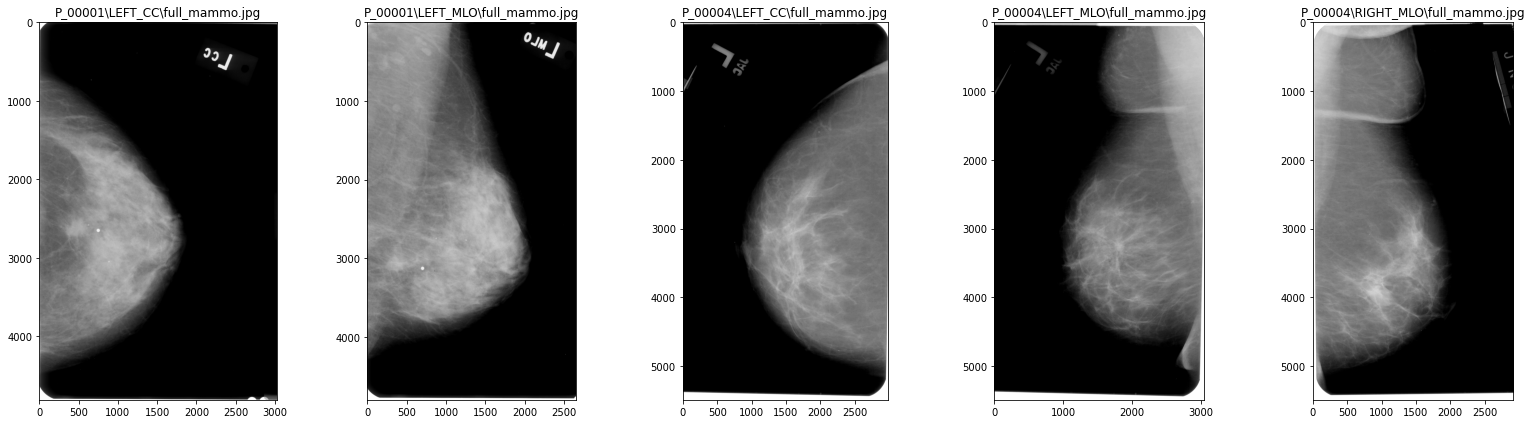

In [7]:
# Plot together
ncols = len(sample_im)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize = (22,6))

for i in range(ncols):
    ax[i].imshow(read_im[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
plt.tight_layout()

## Propriétés des clichés

In [8]:
for a in read_im:
    print("Shape:", a.shape)
    print("Dimensions:", a.ndim)
    print("Type:", type(a))
    print("Data type:", a.dtype)
    print(f"min value, max value: {a.min(), a.max()}")
    print("---")

Shape: (4808, 3024)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint8
min value, max value: (0, 255)
---
Shape: (4800, 2656)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint8
min value, max value: (0, 255)
---
Shape: (5491, 2986)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint8
min value, max value: (0, 255)
---
Shape: (5491, 3046)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint8
min value, max value: (0, 255)
---
Shape: (5491, 2911)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint8
min value, max value: (0, 255)
---


## Recadrement des images

In [19]:
cropped_img_list = [CropBorders(img) for img in read_im]

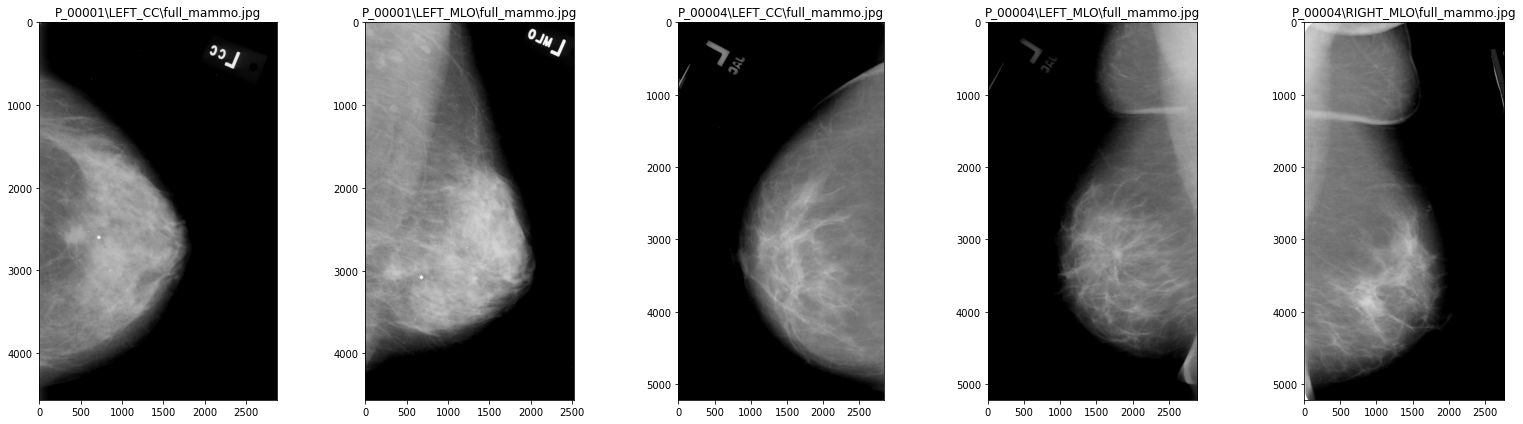

In [22]:
# Plot together
ncols = len(cropped_img_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize = (22,6))

for i in range(ncols):
    ax[i].imshow(cropped_img_list[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
plt.tight_layout()

## Normalisation des images

In [68]:
norm_im = [minmaxnormalise(i) for i in cropped_img_list]

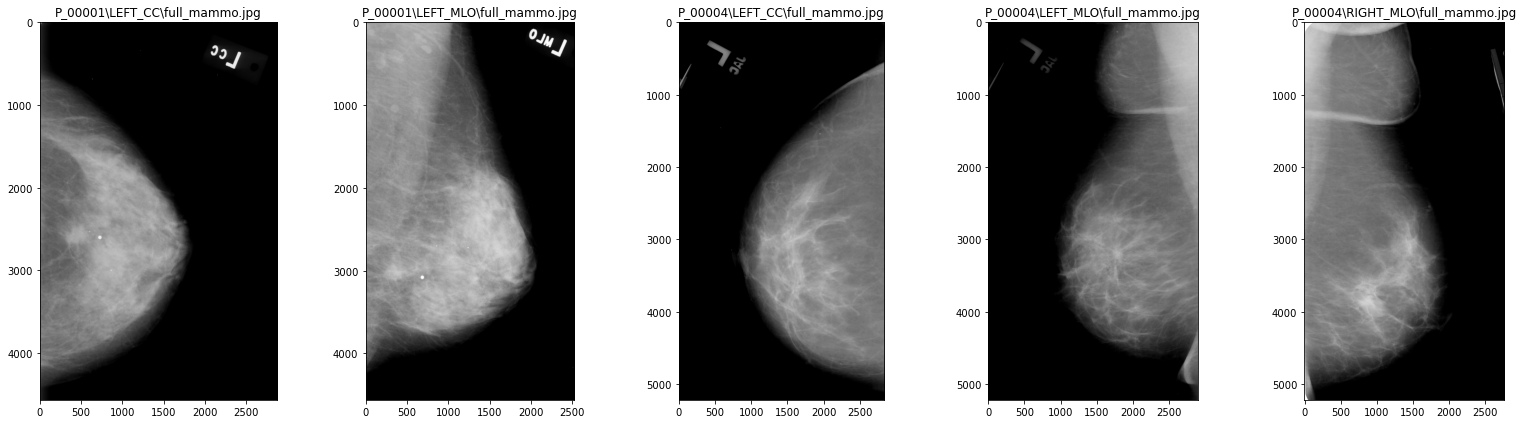

In [69]:
# Plot together
ncols = len(norm_im)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize = (22,6))

for i in range(ncols):
    ax[i].imshow(norm_im[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
plt.tight_layout()

## Binarisation des images

In [70]:
binarised_img_list = [GlobalBinarise(img, 0.1, 1.0) for img in norm_im]

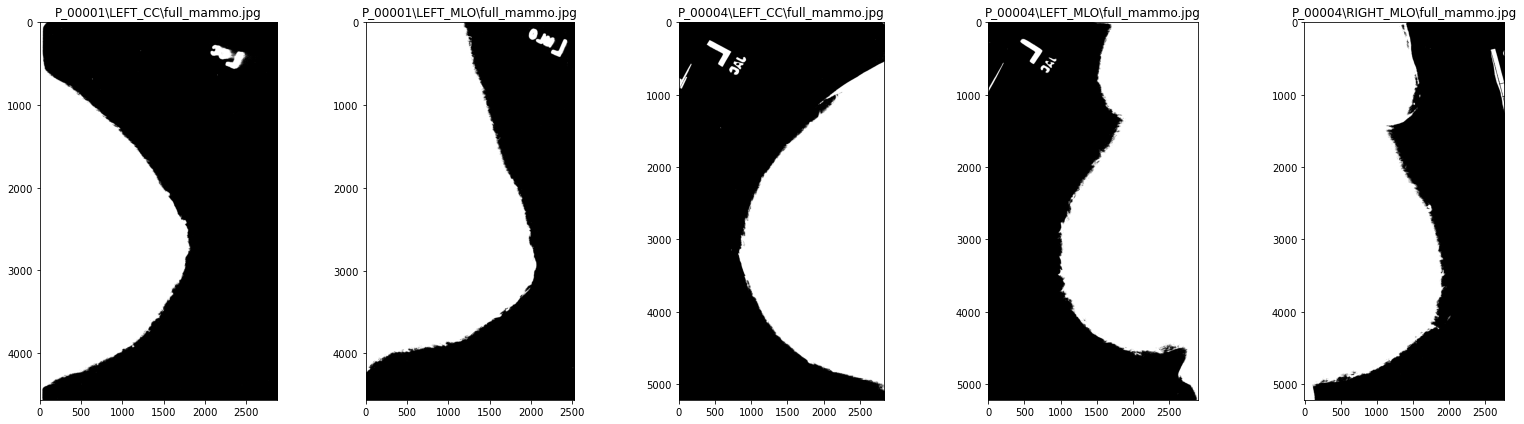

In [71]:
# Plot together
ncols = len(binarised_img_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize = (22,6))

for i in range(ncols):
    ax[i].imshow(binarised_img_list[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
plt.tight_layout()

morphological operations
https://docs.
cv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

### Suppression du bruit du masque

In [72]:
edited_mask_list = [openmask(mask=binarised_img_list[i], ksize=(33, 33), operation="open") for i in range(len(binarised_img_list))]

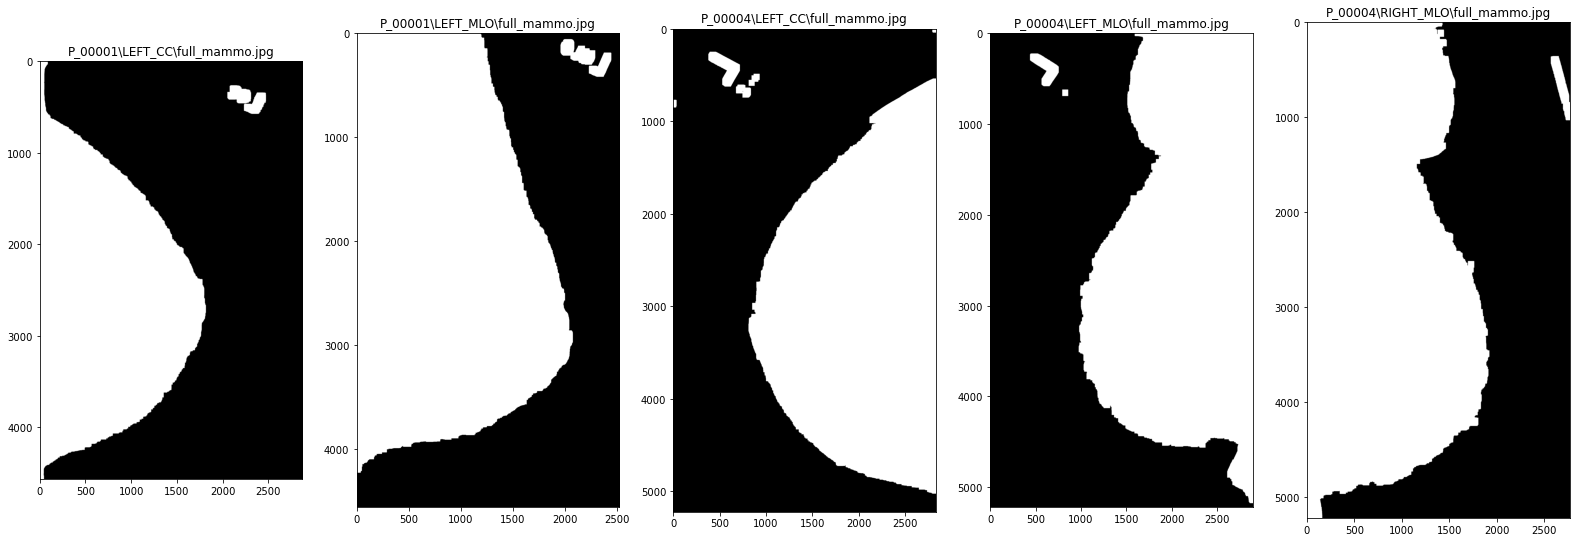

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(22, 10))
for i in range(ncols):
    # Plot edited mask.
    ax[i].imshow(edited_mask_list[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
    
plt.tight_layout()

## Selection de la région voulue

In [74]:
X_largest_blobs_list = [XLargestBlobs(mask=mask, top_X=1)[1] for mask in edited_mask_list]

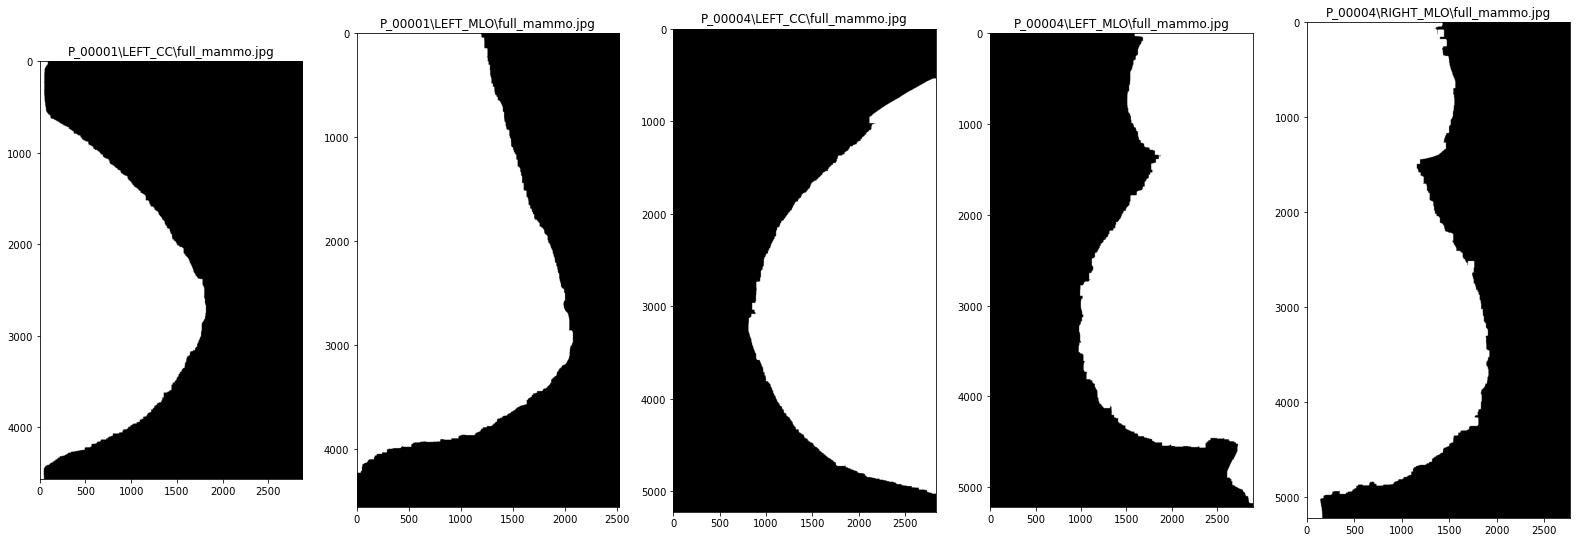

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(22, 10))
for i in range(ncols):
    # Plot largest blob mask.
    ax[i].imshow(X_largest_blobs_list[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
    
plt.tight_layout()

## Application du masque binaire

In [76]:
own_masked_img_list = [ApplyMask(img=cropped_img_list[i], mask=X_largest_blobs_list[i]) for i in range(ncols)]

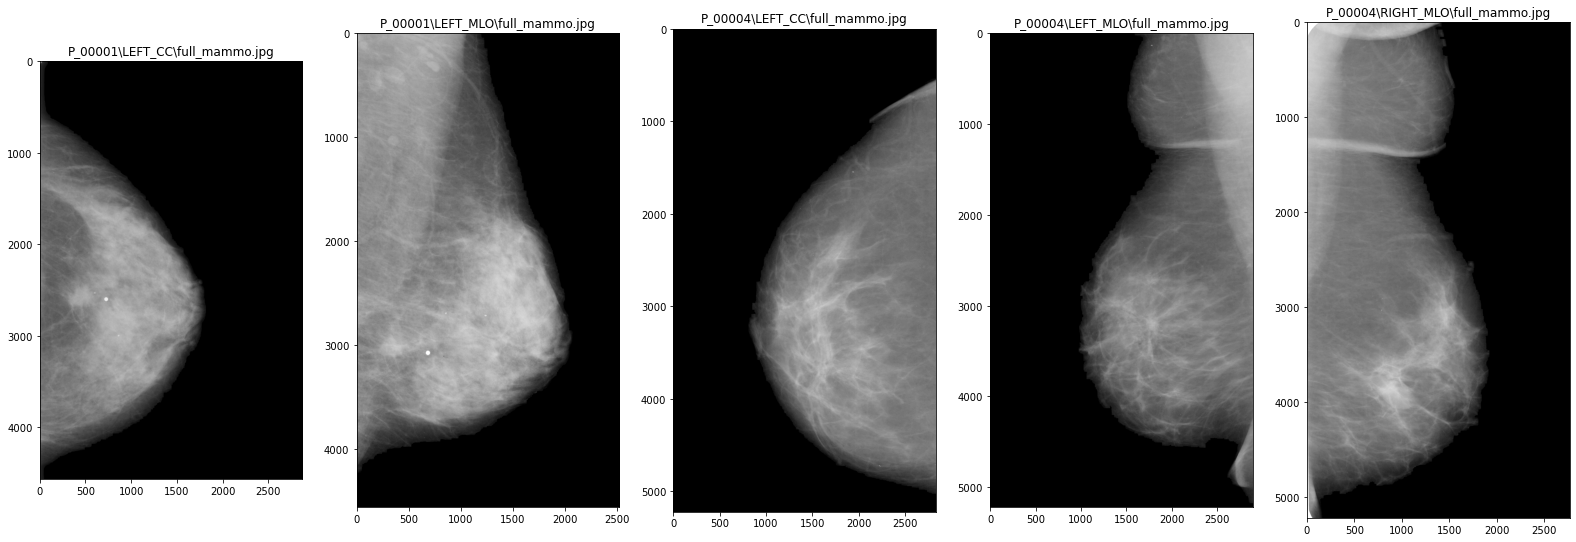

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(22, 10))

for i in range(ncols):
    # Plot edited mask.
    ax[i].imshow(own_masked_img_list[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
    
plt.tight_layout()

## Uniformiser l'orientation des clichés ainsi que les masques qui correspondent

In [78]:
flipped_img_list = []
flipped_ROI_img_list =[]
for i in range(ncols):
    horizontal_flip = flip(mask=X_largest_blobs_list[i])
    flipped_ROI_img = sample_ROI_im[i]
    if horizontal_flip:
        flipped_ROI_img = np.fliplr(sample_ROI_im[i])
        flipped_img = np.fliplr(own_masked_img_list[i])
        
        flipped_ROI_img_list.append(flipped_ROI_img)
        flipped_img_list.append(flipped_img)
    else:
        flipped_ROI_img_list.append(flipped_ROI_img)
        flipped_img_list.append(own_masked_img_list[i])

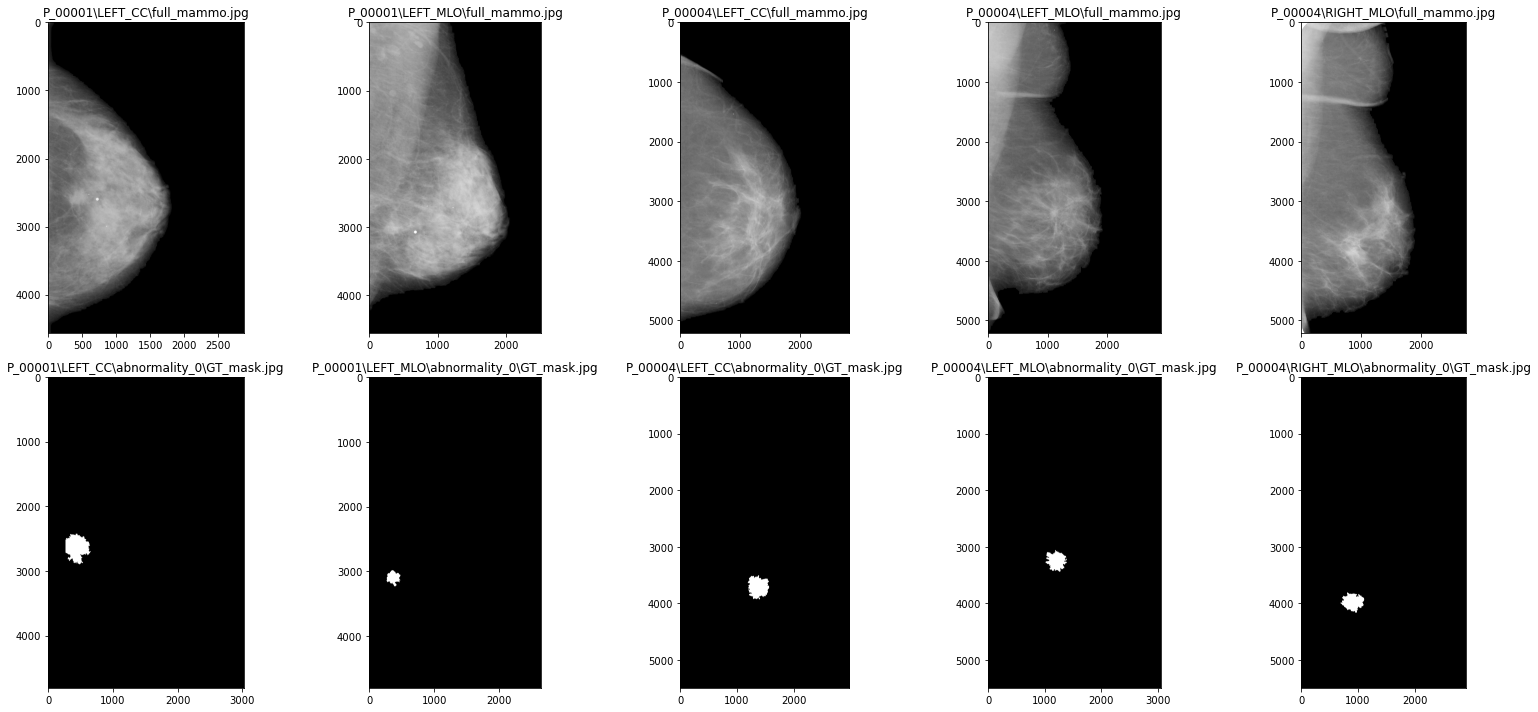

In [79]:
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(22, 10))

for i in range(ncols):
    ax[0][i].imshow(flipped_img_list [i], cmap="gray")
    ax[0][i].set_title(f"{sample[i]}")
    ax[1][i].imshow(flipped_ROI_img_list[i], cmap="gray")
    ax[1][i].set_title(f"{ROI_mask_paths_sample[i]}")

plt.tight_layout()

## Denoising Using median filter

In [80]:
filtered_median= [ cv2.medianBlur(flipped_img_list[i], 3 ) for i in range (ncols) ]

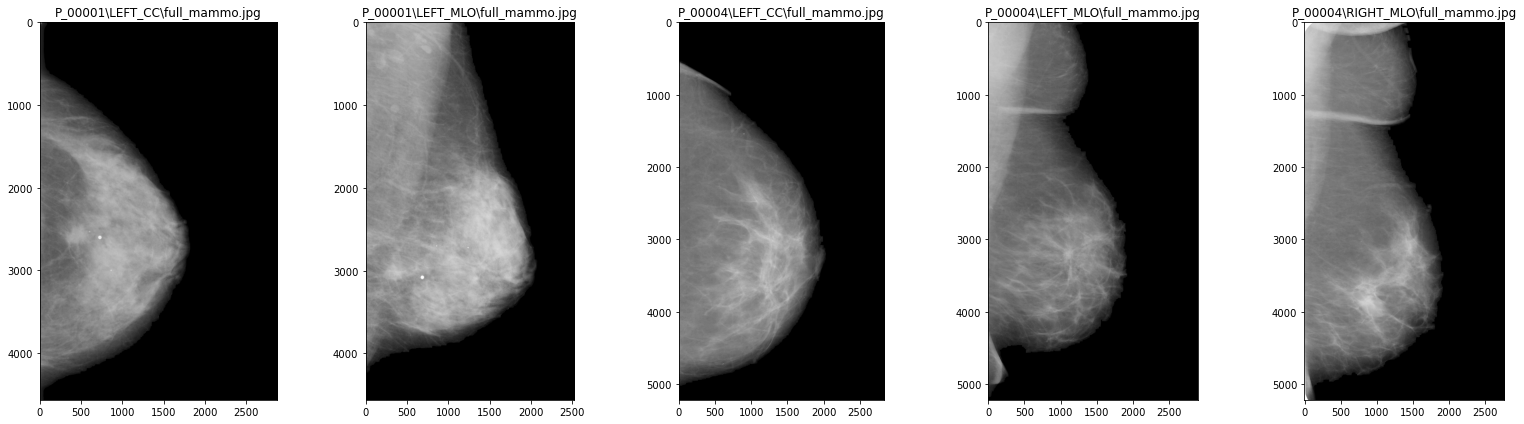

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize = (22,6))

for i in range(ncols):
    ax[i].imshow(filtered_median[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
plt.tight_layout()

## Contrast-Limited Adaptive Histogram Equalisation

In [82]:
clahe_img_list = [clahe(img=filtered_median[i]) for i in range(ncols)]
cv2.imwrite(r'C:\Users\Asus\Desktop\PCD\test_sample.jpg',clahe_img_list[0])

True

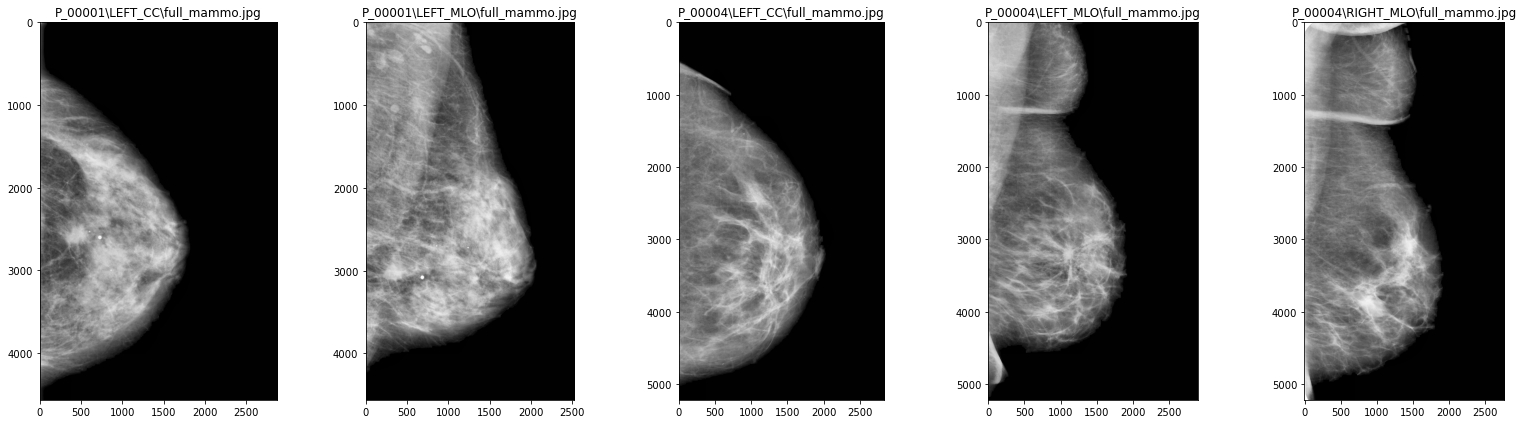

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize = (22,6))

for i in range(ncols):
    ax[i].imshow(clahe_img_list[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")
plt.tight_layout()

### Padding 

In [84]:
padded_img_list = [pad(img=clahe_img_list[i]) for i in range(ncols)]
padded_ROI_img_list = [pad(flipped_ROI_img_list[i]) for i in range(ncols)] # crop this shit brabi

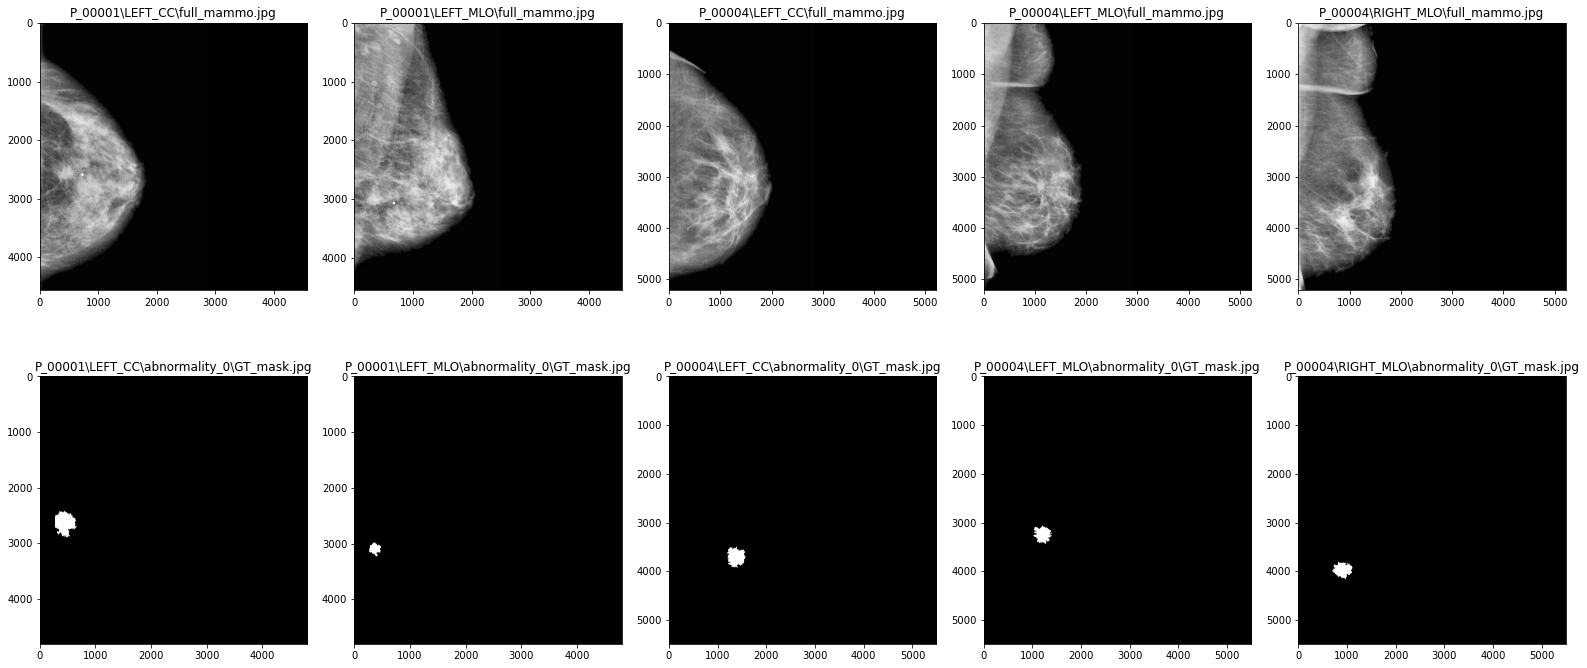

In [85]:
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(22, 10))

for i in range(ncols):
    ax[0][i].imshow(padded_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{sample[i]}")
    ax[1][i].imshow(padded_ROI_img_list[i], cmap="gray")
    ax[1][i].set_title(f"{ROI_mask_paths_sample[i]}")


plt.tight_layout()

## Normalise image

In [86]:
result_prepr = [minmaxnormalise(padded_img_list[i]) for i in range(ncols)]

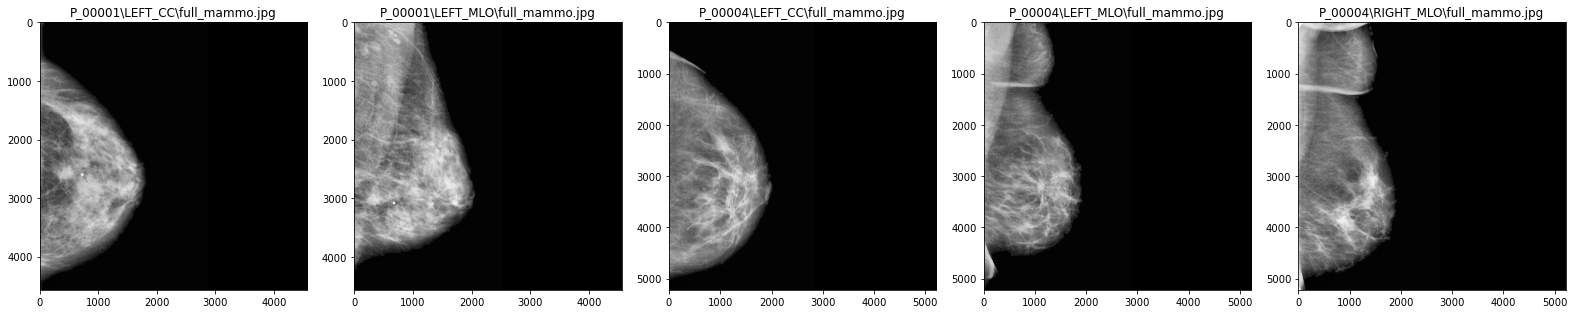

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize = (22,6))

for i in range(ncols):
    ax[i].imshow(result_prepr[i], cmap="gray")
    ax[i].set_title(f"{sample[i]}")

plt.tight_layout()

In [88]:
for a in result_prepr:
    print("Shape:", a.shape)
    print("Dimensions:", a.ndim)
    print("Type:", type(a))
    print("Data type:", a.dtype)
    print(f"min value, max value: {a.min(), a.max()}")
    print("---")

Shape: (4567, 4567)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: float64
min value, max value: (0.0, 1.0)
---
Shape: (4560, 4560)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: float64
min value, max value: (0.0, 1.0)
---
Shape: (5217, 5217)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: float64
min value, max value: (0.0, 1.0)
---
Shape: (5217, 5217)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: float64
min value, max value: (0.0, 1.0)
---
Shape: (5217, 5217)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: float64
min value, max value: (0.0, 1.0)
---
